In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Loading Data
url = "https://raw.githubusercontent.com/gringler8/data5322project/main/NIJ_s_Recidivism_Challenge_Full_Dataset_20240520.csv"
data = pd.read_csv(url)
print(data.shape)

(25835, 54)


In [3]:
# Replace NA/blanks in Gang_Affiliated with "Unknown"
data['Gang_Affiliated'] = data['Gang_Affiliated'].fillna('Unknown')

# Filter out rows with any NAs in the entire dataset
filtered_data = data.dropna().copy()

# Convert specified columns to categorical variables
categorical_columns = [
    'Gender',
    'Race',
    'Age_at_Release',
    'Gang_Affiliated',
    'Supervision_Level_First',
    'Education_Level',
    'Prison_Offense',
    'Prison_Years',
    'Prior_Arrest_Episodes_DVCharges',
    'Prior_Arrest_Episodes_GunCharges',
    'Prior_Conviction_Episodes_Viol',
    'Prior_Conviction_Episodes_PPViolationCharges',
    'Prior_Conviction_Episodes_DomesticViolenceCharges',
    'Prior_Conviction_Episodes_GunCharges',
    'Prior_Revocations_Parole',
    'Prior_Revocations_Probation',
    'Condition_MH_SA',
    'Condition_Cog_Ed',
    'Condition_Other',
    'Violations_ElectronicMonitoring',
    'Violations_Instruction',
    'Violations_FailToReport',
    'Violations_MoveWithoutPermission',
    'Employment_Exempt'
]

for column in categorical_columns:
    filtered_data[column] = filtered_data[column].astype(str)

    # Clean and convert Avg_Days_per_DrugTest to float by removing commas
filtered_data['Avg_Days_per_DrugTest'] = filtered_data['Avg_Days_per_DrugTest'].str.replace(',', '').astype(float)
filtered_data['ID'] = filtered_data['ID'].str.replace(',', '').astype(float)

# Update columns based on the conditions
column_conditions = {
    'Dependents': (3, '3 or more'),
    'Prior_Arrest_Episodes_Felony': (10, '10 or more'),
    'Prior_Arrest_Episodes_Misd': (6, '6 or more'),
    'Prior_Arrest_Episodes_Violent': (3, '3 or more'),
    'Prior_Arrest_Episodes_Property': (5, '5 or more'),
    'Prior_Arrest_Episodes_Drug': (5, '5 or more'),
    'Prior_Arrest_Episodes_PPViolationCharges': (5, '5 or more'),
    'Prior_Conviction_Episodes_Felony': (3, '3 or more'),
    'Prior_Conviction_Episodes_Misd': (4, '4 or more'),
    'Prior_Conviction_Episodes_Prop': (3, '3 or more'),
    'Prior_Conviction_Episodes_Drug': (2, '2 or more'),
    'Delinquency_Reports': (4, '4 or more'),
    'Program_Attendances': (10, '10 or more'),
    'Program_UnexcusedAbsences': (3, '3 or more'),
    'Residence_Changes': (3, '3 or more')
}

# Update the columns based on the conditions
for column, (numeric_value, condition_str) in column_conditions.items():
    filtered_data[column] = filtered_data[column].replace(condition_str, numeric_value).astype(int)

# Columns to exclude from model creation
columns_to_exclude = [
    'Recidivism_Arrest_Year1',
    'Recidivism_Arrest_Year2',
    'Recidivism_Arrest_Year3',
    'Training_Sample',
    'ID'
]

# Keep a separate copy of the excluded columns
excluded_columns_data = filtered_data[columns_to_exclude].copy()

# Drop the excluded columns from the dataset used for model creation
filtered_data_for_model = filtered_data.drop(columns=columns_to_exclude)

In [4]:
# Filter to include only numerical columns and 'Recidivism_Within_3years'
numerical_columns = filtered_data_for_model.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.append('Recidivism_Within_3years')
numeric_model_filter = filtered_data_for_model[numerical_columns]
print(f"Numeric Model Filter: {numeric_model_filter.shape}")

# Separate filter to include dummy variables and categoricals unscaled
numerical_data = filtered_data_for_model[numerical_columns].reset_index(drop=True)
categorical_data = pd.get_dummies(filtered_data_for_model[categorical_columns], drop_first=True).reset_index(drop=True)
dummy_model_filter = pd.concat([numerical_data, categorical_data], axis=1)
print(f"Dummy Model Filter: {dummy_model_filter.shape}")

# Separate filter to scale all dummy variables and numerical variables
scaler = StandardScaler()
columns_to_scale = dummy_model_filter.columns.difference(['Recidivism_Within_3years'])
dummy_model_filter_scaled = dummy_model_filter.copy()
dummy_model_filter_scaled[columns_to_scale] = scaler.fit_transform(dummy_model_filter[columns_to_scale])
print(f"Scaled Dummy Model Filter: {dummy_model_filter_scaled.shape}")

Numeric Model Filter: (16198, 25)
Dummy Model Filter: (16198, 62)
Scaled Dummy Model Filter: (16198, 62)


# Exploring the dataset

In [ ]:
data_columns = dummy_model_filter_scaled.columns.tolist()

for col in data_columns:
  if pd.api.types.is_categorical_dtype(dummy_model_filter_scaled[col]):
        plt.figure()
        sns.countplot(data=dummy_model_filter_scaled, x=col, hue='Gender')
        plt.title(f"Histogram for {col}")
        plt.show()
  elif pd.api.types.is_float_dtype(dummy_model_filter_scaled[col]):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=dummy_model_filter_scaled, y=col, x='Gender')
        plt.title(f"Box Plot for {col}")
        plt.show()
  elif pd.api.types.is_int64_dtype(dummy_model_filter_scaled[col]):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=dummy_model_filter_scaled, y=col, x='Gender')
        plt.title(f"Box Plot for {col}")
        plt.show()


In [ ]:
# preprocessed_data.dtypes

# Outcomes

In [5]:
# Columns to exclude from model creation
columns_to_exclude = [
    'Recidivism_Within_3years',
    'Recidivism_Arrest_Year1',
    'Recidivism_Arrest_Year2',
    'Recidivism_Arrest_Year3',
    'Training_Sample',
    'ID'
]

# Keep a separate copy of the excluded columns
excluded_columns_data = filtered_data[columns_to_exclude].copy()

# Drop the excluded columns from the dataset used for model creation
filtered_data_for_model = filtered_data.drop(columns=columns_to_exclude)

In [6]:
outcomes = excluded_columns_data.drop(['ID', 'Training_Sample'], axis =1 )

all_false_mask = (~outcomes[['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3']].any(axis=1))

year_map = {
    'Recidivism_Arrest_Year1': 'One',
    'Recidivism_Arrest_Year2': 'Two',
    'Recidivism_Arrest_Year3': 'Three'
}

recidivism_arrest_any_index = outcomes[['Recidivism_Arrest_Year1', 'Recidivism_Arrest_Year2', 'Recidivism_Arrest_Year3']].idxmax(axis=1)

outcomes['Recidivism_Arrest_Any'] = recidivism_arrest_any_index.map(year_map)

outcomes.loc[all_false_mask, 'Recidivism_Arrest_Any'] = 'Zero'



In [7]:
dummy_model_filter_scaled = dummy_model_filter_scaled.drop('Recidivism_Within_3years', axis = 1)

# Boosting  multiclass with CV

In [ ]:
X = pd.get_dummies(dummy_model_filter_scaled)
y = outcomes['Recidivism_Arrest_Any']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=200)


In [ ]:
# Learning Rate .1
# GridSearchCV Params
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': list(range(1, 20)),
    'min_samples_split': [50, 100, 150, 200]
}

# Gradient Boosting classifier
boost_recidivism = GradientBoostingClassifier(random_state=100, learning_rate=0.1, max_features = 32)

# GridSearchCV
grid_search = GridSearchCV(estimator=boost_recidivism, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best Params
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters: ", best_params)
print("Best accuracy: {:.2f}".format(best_score))

# Predict
best_model = grid_search.best_estimator_
y_pred_boost = best_model.predict(X_test)

# Accurace
accuracy = accuracy_score(y_test, y_pred_boost)
print("Test accuracy: {:.2f}".format(accuracy))

In [ ]:
# fit Gradient Boosting model
boost_recidivism = GradientBoostingClassifier(n_estimators=200, max_depth=3
                                         , random_state=100, learning_rate = 0.1, max_features = 32)
boost_recidivism.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, n_estimators=50, random_state=100)

In [ ]:
y_pred_boost = boost_recidivism.predict(X_test)

# Accurace
accuracy = accuracy_score(y_test, y_pred_boost)
print("Test accuracy: {:.3f}".format(accuracy))

Test accuracy: 0.591


In [ ]:
# create a dataframe of feature importances and their corresponding column names
importances_boost_recidivism = pd.DataFrame({'Feature': X_train.columns, 'Importance': boost_recidivism.feature_importances_})
importances_boost_recidivism = importances_boost_recidivism.sort_values('Importance', ascending=False).reset_index(drop=True)

# display the table
print(importances_boost_recidivism[:20])

                                     Feature  Importance
0                      Percent_Days_Employed    0.209276
1                              Jobs_Per_Year    0.181423
2                      Avg_Days_per_DrugTest    0.077404
3               Supervision_Risk_Score_First    0.039493
4                        Delinquency_Reports    0.038116
5                     DrugTests_THC_Positive    0.036154
6   Prior_Arrest_Episodes_PPViolationCharges    0.032592
7               Prior_Arrest_Episodes_Felony    0.030571
8                       Gang_Affiliated_True    0.029650
9                          Residence_Changes    0.028978
10                       Program_Attendances    0.024101
11                            Residence_PUMA    0.023300
12                   DrugTests_Meth_Positive    0.021841
13                Prior_Arrest_Episodes_Misd    0.015317
14            Prior_Conviction_Episodes_Misd    0.013448
15                DrugTests_Cocaine_Positive    0.011354
16                  DrugTests_O

In [ ]:
cm = confusion_matrix(y_test, y_pred_boost, labels=boost_recidivism.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=boost_recidivism.classes_)
disp.plot()
plt.show()

# Binary Boosting with added Parameters

In [9]:
X = dummy_model_filter_scaled
y = outcomes['Recidivism_Within_3years']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=200)

In [ ]:
# GridSearchCV Params
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': list(range(1, 20)),
    'min_samples_split': [50, 100, 150, 200]
}

# Gradient Boosting classifier
boost_recidivism = GradientBoostingClassifier(random_state=100, learning_rate=0.1, max_features = 32)

# GridSearchCV
grid_search = GridSearchCV(estimator=boost_recidivism, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best Params
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameters: ", best_params)
print("Best accuracy: {:.2f}".format(best_score))

# Predict
best_model = grid_search.best_estimator_
y_pred_boost = best_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_boost)
print("Test accuracy: {:.4f}".format(accuracy))

In [10]:
# fit Gradient Boosting model
boost_recidivism = GradientBoostingClassifier(n_estimators=200, max_depth=3
                                         , random_state=100, learning_rate=0.1, max_features = 32, min_samples_split = 50)
boost_recidivism.fit(X_train, y_train)

GradientBoostingClassifier(max_features=32, min_samples_split=50,
                           n_estimators=200, random_state=100)

In [11]:
y_pred_boost = boost_recidivism.predict(X_test)

# Accurace
accuracy = accuracy_score(y_test, y_pred_boost)
print("Test accuracy: {:.3f}".format(accuracy))

Test accuracy: 0.736


In [12]:
# create a dataframe of feature importances and their corresponding column names
importances_boost_recidivism = pd.DataFrame({'Feature': X_train.columns, 'Importance': boost_recidivism.feature_importances_})
importances_boost_recidivism = importances_boost_recidivism.sort_values('Importance', ascending=False).reset_index(drop=True)

# display the table
print(importances_boost_recidivism[:20])

                                     Feature  Importance
0                      Percent_Days_Employed    0.281864
1                              Jobs_Per_Year    0.165240
2               Supervision_Risk_Score_First    0.064446
3   Prior_Arrest_Episodes_PPViolationCharges    0.063875
4                       Gang_Affiliated_True    0.063743
5               Prior_Arrest_Episodes_Felony    0.044158
6                      Avg_Days_per_DrugTest    0.037406
7                     DrugTests_THC_Positive    0.032218
8                        Delinquency_Reports    0.024022
9                    DrugTests_Meth_Positive    0.023086
10            Prior_Conviction_Episodes_Misd    0.022183
11                Age_at_Release_48 or older    0.016238
12                         Residence_Changes    0.012854
13                Prior_Arrest_Episodes_Misd    0.012154
14                      Condition_MH_SA_True    0.011088
15                   Gang_Affiliated_Unknown    0.010360
16            Prior_Arrest_Epis

<Axes: >

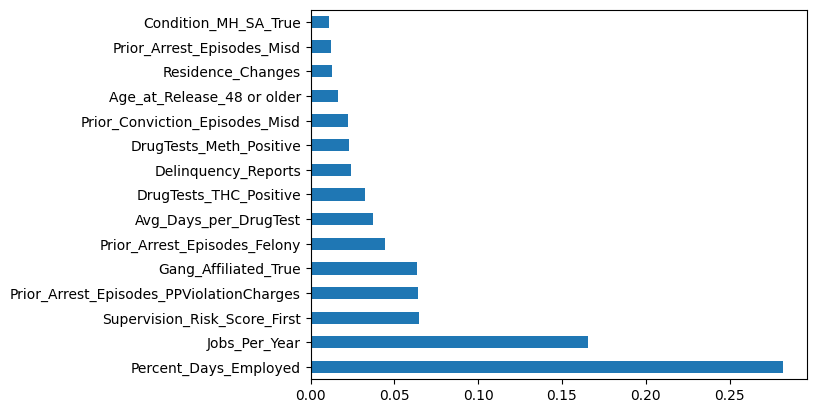

In [15]:
feat_importances = pd.Series(boost_recidivism.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

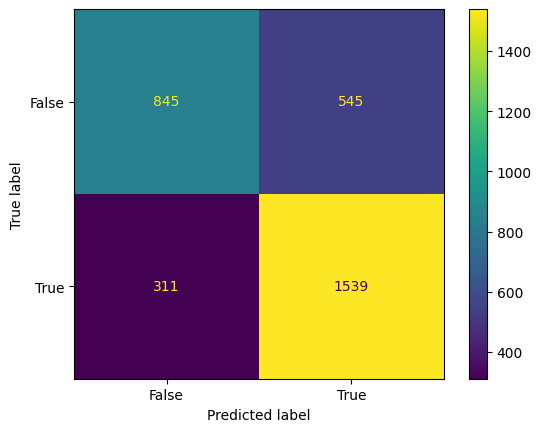

In [13]:
cm = confusion_matrix(y_test, y_pred_boost, labels=boost_recidivism.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=boost_recidivism.classes_)
disp.plot()
plt.show()

# Test Models

In [37]:
female_inmate = data[data['Gender'] == 'F']
female_inmate = female_inmate.drop(['Gender', 'Gang_Affiliated'], axis =1 )

male_inmate = data[data['Gender'] == 'M']
male_inmate = male_inmate.drop(['Gender'], axis =1 )

## Boosting Binary

In [ ]:
X = pd.get_dummies(dummy_model_filter_scaled)
y = outcomes['Recidivism_Within_3years']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=200)

In [ ]:
# GridSearchCV Params
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': list(range(1, 92, 5))
}

# Gradient Boosting classifier
boost_recidivism = GradientBoostingClassifier(random_state=100, learning_rate=0.1)

# GridSearchCV
grid_search = GridSearchCV(estimator=boost_recidivism, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best Params
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters: ", best_params)
print("Best accuracy: {:.2f}".format(best_score))

# Predict
best_model = grid_search.best_estimator_
y_pred_boost = best_model.predict(X_test)

# Accurace
accuracy = accuracy_score(y_test, y_pred_boost)
print("Test accuracy: {:.2f}".format(accuracy))

In [ ]:
# fit Gradient Boosting model
boost_recidivism = GradientBoostingClassifier(n_estimators=100, max_depth=6
                                         , random_state=100, learning_rate = 0.1)
boost_recidivism.fit(X_train, y_train)

In [ ]:
y_pred_boost = boost_recidivism.predict(X_test)

# Accurace
accuracy = accuracy_score(y_test, y_pred_boost)
print("Test accuracy: {:.3f}".format(accuracy))

In [ ]:
# create a dataframe of feature importances and their corresponding column names
importances_boost_recidivism = pd.DataFrame({'Feature': X_train.columns, 'Importance': boost_recidivism.feature_importances_})
importances_boost_recidivism = importances_boost_recidivism.sort_values('Importance', ascending=False).reset_index(drop=True)

# display the table
print(importances_boost_recidivism[:20])

## Random Forest

In [ ]:
X = pd.get_dummies(dummy_model_filter_scaled)
y = pd.get_dummies(outcomes['Recidivism_Arrest_Any'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=200)


In [ ]:
# fit Random Forests model
recidivism_rf = RandomForestRegressor(max_features=6
                                       ,random_state = 1)

recidivism_rf.fit(X_train,y_train)

# Predict values
y_pred_rf = recidivism_rf.predict(X_test)

# find the MSE
print("Mean Squared Error: {:.2f}".format(mean_squared_error(y_test, y_pred_rf)))

Mean Squared Error: 0.15


In [ ]:
# create a dataframe of feature importances and their corresponding column names
importances_recidivism_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': recidivism_rf.feature_importances_})
importances_recidivism_rf = importances_recidivism_rf.sort_values('Importance', ascending=False).reset_index(drop=True)

# display the table
print(importances_recidivism_rf)

                                              Feature  Importance
0                               Percent_Days_Employed    0.064654
1                                       Jobs_Per_Year    0.051033
2                               Avg_Days_per_DrugTest    0.050217
3                                      Residence_PUMA    0.038623
4                        Supervision_Risk_Score_First    0.034431
..                                                ...         ...
75                                           Gender_F    0.004033
76  Prior_Conviction_Episodes_DomesticViolenceChar...    0.004003
77  Prior_Conviction_Episodes_DomesticViolenceChar...    0.003846
78                            Gang_Affiliated_Unknown    0.003587
79                                           Gender_M    0.003468

[80 rows x 2 columns]
